## 필요 모듈 불러오기

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import glob
from PIL import Image
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,Dense,Flatten,Dropout,MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [2]:
# len(glob.glob('/content/drive/MyDrive/안봐도보이조_project/train_10/*/*'))

## 이미지 생성기 선언

In [3]:
train_datagen = ImageDataGenerator( 
        rescale=1./255,         # 픽셀 값을 0~1 범위로 변환
        rotation_range=40,      # 40도까지 회전
        width_shift_range=0.2,  # 20%까지 좌우 이동
        height_shift_range=0.2, # 20%까지 상하 이동
        shear_range=0.2,        # 20%까지 기울임
        zoom_range=0.2,         # 20%까지 확대
        horizontal_flip=True,   # 좌우 뒤집기
    )
train_generator = train_datagen.flow_from_directory(
    './train_10',
    batch_size=50,      
    class_mode='categorical', 
    target_size=(64, 64)) 
valid_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
valid_generator = valid_datagen.flow_from_directory(
    './valid_10',
    batch_size=20,      
    class_mode='categorical', 
    target_size=(64, 64))
test_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
test_generator = test_datagen.flow_from_directory(
    './test_10',
    batch_size=10,      
    class_mode='categorical', 
    target_size=(64, 64), shuffle = False)

Found 10529 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


## 모델 생성 및 학습
- ResNet50 모델 사용
- early_stopping, modelcheckpoint 적용

In [4]:
resnet50 = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(64 ,64 ,3))

# resnet50.trainable = False
model = Sequential()
model.add(resnet50)
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 10)                81930     
                                                                 
Total params: 23,669,642
Trainable params: 23,616,522
Non-trainable params: 53,120
_________________________________________________________________


In [5]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

- optimizer의 learning rate 조절해보기

In [6]:
# #early_stopping
# early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

In [7]:
# model_path = './model/RedNet50.hdf5'

# checkpointer = ModelCheckpoint(filepath=model_path, monitor='val_loss', 
#                                verbose=1, save_best_only=True)

In [8]:
history = model.fit(train_generator,
#                     batch_size=64,
                    steps_per_epoch=10529//50, 
                    epochs=10, 
                    validation_data=valid_generator,
                    validation_batch_size=8,
                    validation_steps=1000//20,
#                     callbacks=[early_stopping_callback]
                   )

Epoch 1/10
210/210 [==============================] - 177s 829ms/step - loss: 0.4720 - accuracy: 0.8865 - val_loss: 2.3627 - val_accuracy: 0.1020
Epoch 2/10
210/210 [==============================] - 166s 791ms/step - loss: 0.1149 - accuracy: 0.9654 - val_loss: 2.3113 - val_accuracy: 0.1000
Epoch 3/10
210/210 [==============================] - 167s 795ms/step - loss: 1.1356 - accuracy: 0.8319 - val_loss: 62902.3359 - val_accuracy: 0.1000
Epoch 4/10
210/210 [==============================] - 166s 788ms/step - loss: 0.3316 - accuracy: 0.8879 - val_loss: 2.1433 - val_accuracy: 0.4180
Epoch 5/10
210/210 [==============================] - 165s 787ms/step - loss: 0.1516 - accuracy: 0.9462 - val_loss: 1.8870 - val_accuracy: 0.6000
Epoch 6/10
210/210 [==============================] - 165s 787ms/step - loss: 0.0974 - accuracy: 0.9658 - val_loss: 0.1400 - val_accuracy: 0.9460
Epoch 7/10
210/210 [==============================] - 165s 786ms/step - loss: 0.1337 - accuracy: 0.9635 - val_loss: 0.05

In [9]:
model.evaluate(test_generator)

50/50 [==============================] - 3s 54ms/step - loss: 1.0441 - accuracy: 0.8460


[1.0441482067108154, 0.8460000157356262]

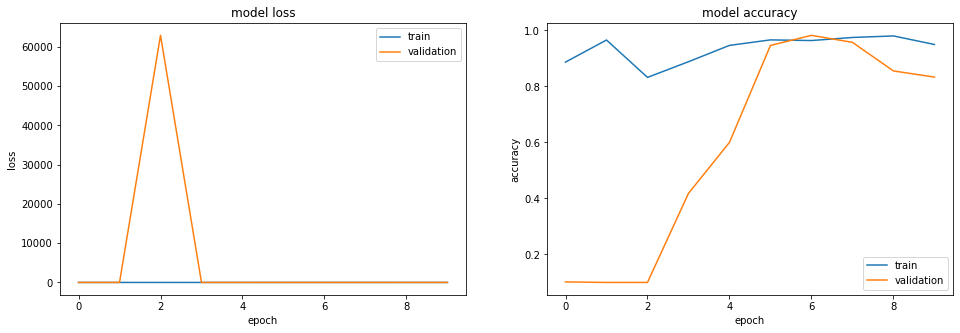

In [10]:
# 모델 학습 과정 시각화
plt.figure(figsize=(16,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

In [11]:
model.save('./model/ResNet_3.h5')

In [12]:
import cv2

In [13]:
# 새로운 데이터로 예측 결과 확인
test_img = cv2.imread('./123.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img = cv2.resize(test_img,(64,64))/255.0
test_img = test_img.reshape((1,)+test_img.shape)
pred = model.predict(test_img)
pred

array([[5.4493546e-04, 8.4738910e-01, 5.7727890e-04, 1.2943087e-02,
        2.9743118e-03, 4.6326715e-02, 4.1982438e-04, 2.5948187e-04,
        8.8267297e-02, 2.9793126e-04]], dtype=float32)

In [14]:
pred.argmax()

1

In [15]:
train_generator.class_indices

{'갈아만든배': 0,
 '레쓰비': 1,
 '마운틴듀': 2,
 '밀키스': 3,
 '스프라이트': 4,
 '칠성사이다': 5,
 '코카콜라': 6,
 '트로피카나망고': 7,
 '펩시콜라': 8,
 '환타오렌지': 9}

In [16]:
result_dict = dict(map(reversed, train_generator.class_indices.items()))
# 딕셔너리의 key, values 뒤집기
result_dict

{0: '갈아만든배',
 1: '레쓰비',
 2: '마운틴듀',
 3: '밀키스',
 4: '스프라이트',
 5: '칠성사이다',
 6: '코카콜라',
 7: '트로피카나망고',
 8: '펩시콜라',
 9: '환타오렌지'}

In [17]:
result_dict[pred.argmax()]

'레쓰비'

In [18]:
categories = list(result_dict.values())
# 딕셔너리의 value 값을 리스트로 받기
categories

['갈아만든배',
 '레쓰비',
 '마운틴듀',
 '밀키스',
 '스프라이트',
 '칠성사이다',
 '코카콜라',
 '트로피카나망고',
 '펩시콜라',
 '환타오렌지']

In [19]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
# from tensorflow.keras.models import load_model
# model = load_model('./VGG16_1.h5')

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

np.set_printoptions(precision=2)

Y_pred = model.predict(test_generator)
classes = test_generator.classes[test_generator.index_array]
y_pred = np.argmax(Y_pred, axis=1)  # Returns maximum indices in each row

class_names = categories

print('-- Confusion Matrix --')
print(confusion_matrix(classes, y_pred))



print('-- Classification Report --')
print(classification_report(classes, y_pred, target_names=class_names))

-- Confusion Matrix --
[[48  0  0  1  0  1  0  0  0  0]
 [ 0 44  0  2  0  0  0  0  4  0]
 [ 0  0 39  0  1 10  0  0  0  0]
 [ 0  0  0 47  1  2  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0 50  0  0]
 [ 0  1  0  0  0  4  0  0 45  0]
 [ 0  0  0  0  0  0  0  0  0 50]]
-- Classification Report --
              precision    recall  f1-score   support

       갈아만든배       1.00      0.96      0.98        50
         레쓰비       0.98      0.88      0.93        50
        마운틴듀       1.00      0.78      0.88        50
         밀키스       0.94      0.94      0.94        50
       스프라이트       0.00      0.00      0.00        50
       칠성사이다       0.43      1.00      0.60        50
        코카콜라       1.00      1.00      1.00        50
     트로피카나망고       1.00      1.00      1.00        50
        펩시콜라       0.92      0.90      0.91        50
       환타오렌지       1.00      1.00      1.00        50

    accuracy          

<AxesSubplot:>

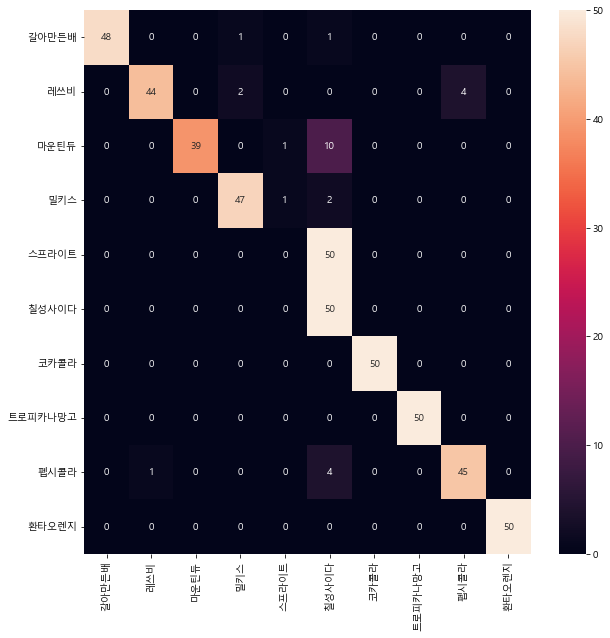

In [21]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(classes, y_pred), annot=True, fmt='d',
            xticklabels=categories,
            yticklabels=categories)
# 코랩에서 한글 도저히 안나오는듯
# 뒤에부분은 로컬에서 주피터로 진행해서 히트맵뽑기